#Nystrom Approximation in KeOps: Benchmarking

**Other Libraries**

In terms of other libraries, we only compare KeOps to Scikit learn, as that is the only commonly used library that has implemented the Nystrom approximation method. We will compare performance both in terms of speed & precision.

**Benchmarking within KeOps**

We will analyze performance on randomly generated data of varying sizes as well as performance on well-known datasets (e.g. MNIST).

In [ ]:
# If using colab, make sure you install via:  !pip install pykeops[full] > log.log
# makes plot outputs appear and be stored within the notebook
%matplotlib inline 
!pip install si_prefix
!pip install sphinx
!pip install pykeops[full] > log.log

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/keops

/content/drive/MyDrive/keops


In [5]:
import sys
sys.path.append('/content/drive/MyDrive/keops')

In [6]:
import numpy as np
import torch
#import pykeops

import matplotlib.pyplot as plt
import time

from sklearn.kernel_approximation import Nystroem
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import rbf_kernel

from nystrom_master_code import Nystrom_NK
from Nystrom_TK import LazyNystrom_TK as Nystrom_TK

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader

###Benchmark Specifications

In [7]:
# Number of sub-samples we want to test the algorithm speed on

# Add more later, the benchmarks on the KeOps website go up to 5M (in the 1 / 2 / 5 fashion)

NS = [
    100,
    200,
    500,
    1000,
    2000,
    5000
]

kernels = ['rbf', 'exp']

length = 10000

use_cuda = torch.cuda.is_available()
print(use_cuda)

True


####Data sets

In [8]:
# data set 1: basic
random_data = np.random.uniform(0,100,size = (length,3))
random_data_t = torch.tensor(random_data, dtype=torch.float32)

# data set 2: with clusters
data_clustered, _ = make_blobs(n_samples= length, n_features=3, centers=5)
data_clustered_t = torch.tensor(data_clustered, dtype=torch.float32)

In [ ]:
# data set 3: MNIST

train_loader = DataLoader(MNIST('/files/', train=True, download=True,
                                transform=Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])),
                          batch_size=length, shuffle=True)

examples = enumerate(train_loader)
_, (example_data, _) = next(examples)

# create two versions of the data set, on
#MNIST_t = example_data.permute(1,0,2,3)
MNIST_t = example_data
MNIST = MNIST_t.numpy()

Benchmarking: Main

In [10]:
def get_runtime(X, X_t, data_name):
    keops_t = []
    keops_torch_t = []
    sklearn_t  = []

    for n_components in NS:
        # keops Numpy
        nystrom = Nystrom_NK(kernel = 'rbf', random_state = 0, n_components=n_components)
        start = time.time()
        n_fit = nystrom.fit(X)
        end = time.time()
        elapsed = end - start
        print(f"KeOps NumPy, {n_components} components, time taken: {round(elapsed, 2)}s.")
        keops_t.append(elapsed)

        # keops Torch
        nystrom = Nystrom_TK(kernel = 'rbf', random_state = 0, n_components=n_components)
        start = time.time()
        n_fit = nystrom.fit(X_t)
        end = time.time()
        elapsed = end - start
        print(f"KeOps Torch, {n_components} components, time taken: {round(elapsed, 2)}s.")
        keops_torch_t.append(elapsed)

        # sklearn
        start = time.time()
        sk_n = Nystroem(kernel='rbf', gamma=1., n_components=n_components, random_state=0).fit(X)
        end = time.time()
        elapsed = end - start
        print(f"Sklearn, {n_components} components, time taken: {round(elapsed, 2)}s.")
        sklearn_t.append(elapsed)

    plt.plot(NS, keops_t, marker ="o", label = 'KeOps NumPy')
    plt.plot(NS, sklearn_t, marker = "x", label = 'Sklearn')
    plt.plot(NS, keops_torch_t, marker = "*", label = 'KeOps Torch')
    plt.legend()
    plt.xlabel("Number of components")
    plt.ylabel("Time elapsed (s)")
    plt.title(f"KeOps vs Scikit-learn runtimes on {data_name}")
    plt.grid(True, which="major", linestyle="dotted")
    plt.show()

KeOps NumPy, 100 components, time taken: 0.09s.
KeOps Torch, 100 components, time taken: 0.02s.
Sklearn, 100 components, time taken: 0.01s.
KeOps NumPy, 200 components, time taken: 0.2s.
KeOps Torch, 200 components, time taken: 0.03s.
Sklearn, 200 components, time taken: 0.04s.
KeOps NumPy, 500 components, time taken: 0.66s.
KeOps Torch, 500 components, time taken: 0.11s.
Sklearn, 500 components, time taken: 0.16s.
KeOps NumPy, 1000 components, time taken: 2.66s.
KeOps Torch, 1000 components, time taken: 0.32s.
Sklearn, 1000 components, time taken: 0.88s.
KeOps NumPy, 2000 components, time taken: 15.09s.
KeOps Torch, 2000 components, time taken: 1.92s.
Sklearn, 2000 components, time taken: 4.41s.
KeOps NumPy, 5000 components, time taken: 337.23s.
KeOps Torch, 5000 components, time taken: 33.91s.
Sklearn, 5000 components, time taken: 77.54s.


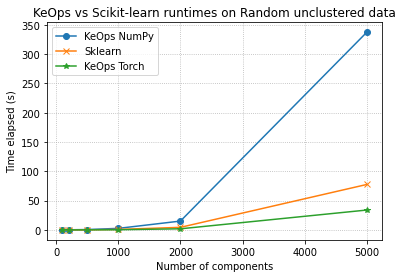

KeOps NumPy, 100 components, time taken: 0.09s.
KeOps Torch, 100 components, time taken: 0.02s.
Sklearn, 100 components, time taken: 0.01s.
KeOps NumPy, 200 components, time taken: 0.31s.
KeOps Torch, 200 components, time taken: 0.03s.
Sklearn, 200 components, time taken: 0.03s.
KeOps NumPy, 500 components, time taken: 1.33s.
KeOps Torch, 500 components, time taken: 0.12s.
Sklearn, 500 components, time taken: 0.14s.
KeOps NumPy, 1000 components, time taken: 5.7s.
KeOps Torch, 1000 components, time taken: 0.53s.
Sklearn, 1000 components, time taken: 0.73s.
KeOps NumPy, 2000 components, time taken: 38.31s.
KeOps Torch, 2000 components, time taken: 3.36s.
Sklearn, 2000 components, time taken: 4.3s.
KeOps NumPy, 5000 components, time taken: 721.4s.
KeOps Torch, 5000 components, time taken: 45.43s.
Sklearn, 5000 components, time taken: 77.04s.


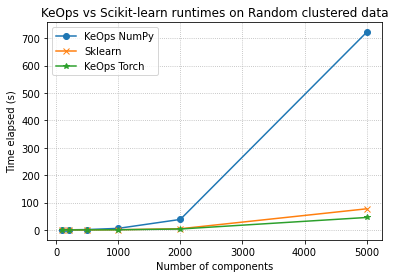

In [ ]:
get_runtime(random_data, random_data_t, 'Random unclustered data')
get_runtime(data_clustered, data_clustered_t, 'Random clustered data')

In [ ]:
# TO DO
# Currently does not run, not sure if it's the data or our code

# get_runtime(MNIST, MNIST_t, 'MNIST data set (10k samples)')

**Something to look into!!!**

The below illustrates that there's something strange going on with X_ transform.
For unclustered data, Nystrom_NK returns practically a zero matrix.

For the clustered data, the results of our and Sklearn data sets are wildly different.

In [ ]:
n_samples = 1000
n_components = 100

data_clustered_s, _ = make_blobs(n_samples= 1000, n_features=3, centers=5)
random_data_s = np.random.uniform(0,100,size = (length,3))

print('Random unclustered data')
print('')
nystrom = Nystrom_NK(kernel = 'rbf', random_state = 0, n_components=n_components).fit(random_data_s)
x_new = nystrom.transform(random_data_s)
print('keops shape', x_new.shape)
print('keops sum', x_new.sum())

sk_n = Nystroem(kernel='rbf', gamma=1., n_components=n_components, random_state=0).fit(random_data_s)
x_new_sk = sk_n.transform(random_data_s)
print('sklearn shape', x_new_sk.shape)
print('sklearn sum', x_new_sk.sum())

print('Random clustered data')
print('')
nystrom = Nystrom_NK(kernel = 'rbf', random_state = 0, n_components=n_components).fit(data_clustered_s)
x_new = nystrom.transform(data_clustered_s)
print('keops shape', x_new.shape)
print('keops sum', x_new.sum())

sk_n = Nystroem(kernel='rbf', gamma=1., n_components=n_components, random_state=0).fit(data_clustered_s)
x_new_sk = sk_n.transform(data_clustered_s)
print('sklearn shape', x_new_sk.shape)
print('sklearn sum', x_new_sk.sum())

Random unclustered data

keops shape (10000, 100)
keops sum 7.771742104374154e-40
sklearn shape (10000, 100)
sklearn sum 106.22015067655146
Random clustered data

keops shape (1000, 100)
keops sum -450332.55045845784
sklearn shape (1000, 100)
sklearn sum 1134.564507264352


Average distances

In [17]:
def get_avg_dist(data, data_t, data_name):
    ns = [50, 100, 200, 500, 1000] # corresponds to 5%, 10%, 20%, 50% and the full data set

    avg_dists = []
    for n_comp in ns:
        distances = []
        nystrom = Nystrom_NK(kernel = 'rbf', random_state = 0, n_components=n_comp).fit(data)
        for sample in data:
            dist = min([np.linalg.norm(sample-b_sample) for b_sample in nystrom.components_])
            distances.append(dist)
        mean_dist = sum(distances) / len(distances)
        print(f"The mean distance when sampling {n_comp} components is {round(mean_dist, 2)}.")
        avg_dists.append(mean_dist)

    avg_dists_2 = []
    for n_comp in ns:
        distances = []
        nystrom =Nystroem(kernel = 'rbf', random_state = 0, n_components=n_comp).fit(data)
        for sample in data:
            dist = min([np.linalg.norm(sample-b_sample) for b_sample in nystrom.components_])
            distances.append(dist)
        mean_dist = sum(distances) / len(distances)
        print(f"The mean distance when sampling {n_comp} components is {round(mean_dist, 2)}.")
        avg_dists_2.append(mean_dist)

    avg_dists_3 = []
    for n_comp in ns:
        distances = []
        nystrom = Nystrom_TK(kernel = 'rbf', random_state = 0, n_components=n_comp).fit(data_t)
        for sample in data_t:
            dist = min([np.linalg.norm(sample-b_sample) for b_sample in nystrom.components_])
            distances.append(dist)
        mean_dist = sum(distances) / len(distances)
        print(f"The mean distance when sampling {n_comp} components is {round(mean_dist, 2)}.")
        avg_dists_3.append(mean_dist)

    plt.plot(ns, avg_dists, marker ="o", label = 'KeOps NumPy')
    plt.plot(ns, avg_dists, marker ="*", label = 'Sklearn')
    plt.plot(ns, avg_dists_3, marker = "x", label = 'KeOps Torch')
    plt.legend()
    plt.xlabel("Number of components")
    plt.ylabel("Distance (absolute)")
    plt.title(f"Mean distance from nearest neighbour based on n_components on {data_name}")
    plt.grid(True, which="major", linestyle="dotted")
    plt.show()

The mean distance when sampling 50 components is 16.3.
The mean distance when sampling 100 components is 12.84.
The mean distance when sampling 200 components is 9.8.
The mean distance when sampling 500 components is 6.99.
The mean distance when sampling 1000 components is 5.15.
The mean distance when sampling 50 components is 16.3.
The mean distance when sampling 100 components is 12.84.
The mean distance when sampling 200 components is 9.8.
The mean distance when sampling 500 components is 6.99.
The mean distance when sampling 1000 components is 5.15.
The mean distance when sampling 50 components is 16.3.
The mean distance when sampling 100 components is 12.84.
The mean distance when sampling 200 components is 9.8.
The mean distance when sampling 500 components is 6.99.
The mean distance when sampling 1000 components is 5.15.


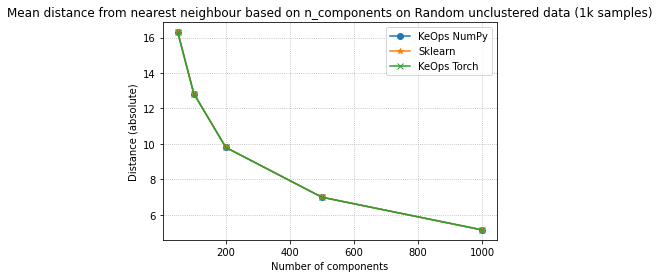

The mean distance when sampling 50 components is 1.01.
The mean distance when sampling 100 components is 0.78.
The mean distance when sampling 200 components is 0.54.
The mean distance when sampling 500 components is 0.26.
The mean distance when sampling 1000 components is 0.0.
The mean distance when sampling 50 components is 1.01.
The mean distance when sampling 100 components is 0.78.
The mean distance when sampling 200 components is 0.54.
The mean distance when sampling 500 components is 0.26.
The mean distance when sampling 1000 components is 0.0.
The mean distance when sampling 50 components is 1.01.
The mean distance when sampling 100 components is 0.78.
The mean distance when sampling 200 components is 0.54.
The mean distance when sampling 500 components is 0.26.
The mean distance when sampling 1000 components is 0.0.


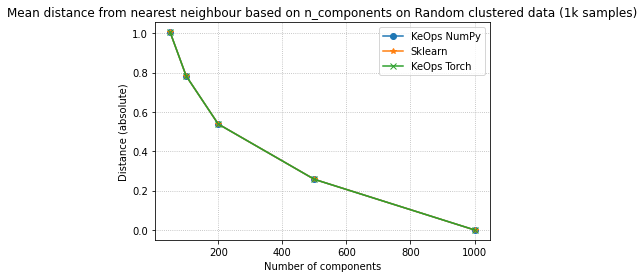

In [18]:
data_clustered_s, _ = make_blobs(n_samples= 1000, n_features=3, centers=5)
random_data_s = np.random.uniform(0,100,size = (length,3))

random_data_s_t = torch.tensor(random_data_s, dtype=torch.float32)
data_clustered_s_t = torch.tensor(data_clustered_s, dtype=torch.float32)

get_avg_dist(random_data_s, random_data_s_t, 'Random unclustered data (1k samples)')
get_avg_dist(data_clustered_s, data_clustered_s_t, 'Random clustered data (1k samples)')

#get_avg_dist(MNIST[:1000], MNIST_t[:1000], 'MNIST (1k samples)')

Differences resulting from random seed selection are minor. \\
As of now, this is not saying as much because it depends on the data scale etc, but if we implement more sophisticated sampling, it will be useful to compare the mean distance given the same data but different sampling.

###Average distance in Scikit-learn

In [ ]:
ns = [50, 100, 200, 500, 1000]
avg_dists = []

for n_comp in ns:
    distances = []
    nystrom = Nystroem(kernel='rbf', gamma=1., n_components=n_comp, random_state=0).fit(X)
    for sample in X:
        dist = min([np.linalg.norm(sample-b_sample) for b_sample in nystrom.components_])
        distances.append(dist)
    mean_dist = sum(distances) / len(distances)
    print(f"The mean distance when sampling {n_comp} components is {round(mean_dist, 2)}.")
    avg_dists.append(mean_dist)

The mean distance when sampling 50 components is 14.9.
The mean distance when sampling 100 components is 11.48.
The mean distance when sampling 200 components is 8.11.
The mean distance when sampling 500 components is 3.64.
The mean distance when sampling 1000 components is 0.0.


Right now Sklearn hasthe same distances, but we could improve by better sampling.

### Kernel approximation Error


Right now this code keeps crashing (some issues with KeOps \& compilation).

In [ ]:
'''
length = 5000

use_cuda = torch.cuda.is_available()

X = np.random.uniform(0,100,size = (length,3))
X_t = torch.rand(size = (length,3))*100
NS = [50, 100, 200, 500, 1000, 2000, 5000]
errors_n = []
errors_t = []

k = rbf_kernel(X)

   
for n_comps in NS:
    '''
    # keops Torch
    nystrom = Nystrom_TK(kernel = 'rbf', random_state = 0, n_components=n_comps).fit(X_t)
    k_approx = nystrom.K_approx(X_t)
    error = np.linalg.norm(k-k_approx.detach())
    errors_t.append(error)
    print(f"For {n_components} components the approximation error is {error}.")
    '''
    # keops Numpy
    nystrom = Nystrom_NK(kernel = 'rbf', random_state = 0, n_components=n_comps).fit(X)
    k_approx = nystrom.K_approx(X)
    error = np.linalg.norm(k-k_approx)
    errors_n.append(error)
    print(f"For {n_components} components the approximation error is {error}.")

plt.plot(NS, errors_n, marker ="o", label = 'rbf kernel')
plt.legend()
plt.xlabel("Number of components")
plt.ylabel("Approximation error")
plt.title("Kernel approximation error based on n_components")
plt.grid(True, which="major", linestyle="dotted")
plt.show()
'''

Compiling libKeOpsnumpy238409c5fe in /root/.cache/pykeops-1.4.2-cpython-37:
       formula: Sum_Reduction((Exp(Minus(Sum(Square((Var(0,3,0) - Var(1,3,1)))))) * Var(2,1,1)),0)
       aliases: Var(0,3,0); Var(1,3,1); Var(2,1,1); 
       dtype  : float64
... 
--------------------- MAKE DEBUG -----------------
Command '['cmake', '--build', '.', '--target', 'libKeOpsnumpy238409c5fe', '--', 'VERBOSE=1']' returned non-zero exit status 2.
/usr/local/lib/python2.7/dist-packages/cmake/data/bin/cmake -H/usr/local/lib/python3.7/dist-packages/pykeops -B/root/.cache/pykeops-1.4.2-cpython-37/build-libKeOpsnumpy238409c5fe --check-build-system CMakeFiles/Makefile.cmake 0
/usr/bin/make -f CMakeFiles/Makefile2 libKeOpsnumpy238409c5fe
make[1]: Entering directory '/root/.cache/pykeops-1.4.2-cpython-37/build-libKeOpsnumpy238409c5fe'
/usr/local/lib/python2.7/dist-packages/cmake/data/bin/cmake -H/usr/local/lib/python3.7/dist-packages/pykeops -B/root/.cache/pykeops-1.4.2-cpython-37/build-libKeOpsnumpy238409c5f

ModuleNotFoundError: ignored